In [ ]:
# We will detect the solar disk, and we will remove those.

solar_image_array max 255
solar_image_array min 0


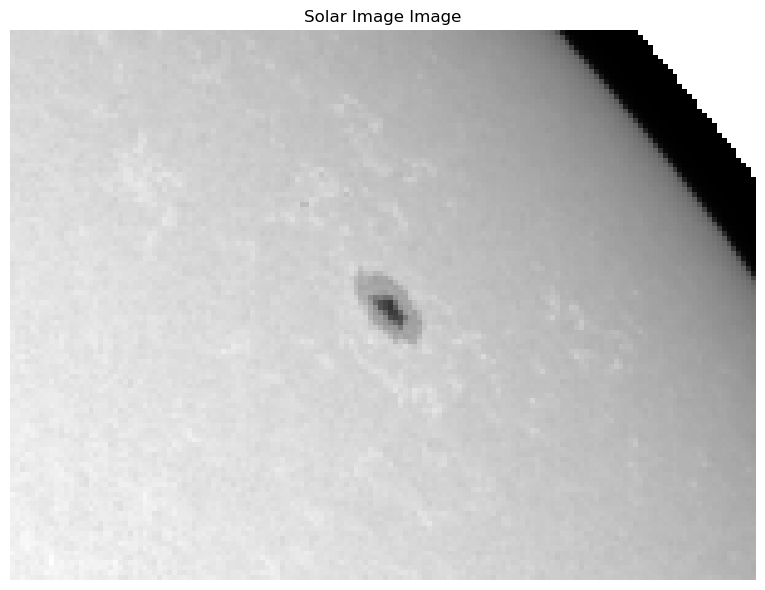

In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Great article about the hough transform using open cv, cv2
# https://pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/

# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
# Load and convert images to grayscale
solar_image = Image.open("../Solar_disk_hough_transformation/sample_images/20110110_065810_AR11140 copy.png").convert("L")

# Convert the images to NumPy arrays
solar_image_array = np.array(solar_image, dtype=np.uint8)

# Print min and max values for coin image
print("solar_image_array max", solar_image_array.max())
print("solar_image_array min", solar_image_array.min())

# Create a figure with 1 row and 2 columns for the images
fig, axs = plt.subplots(figsize=(12, 6))

# Display the first image with a title on top
axs.imshow(solar_image_array, cmap='gray')
axs.set_title("Solar Image Image")
axs.axis('off')  # Turn off axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [36]:
# Here, I am using sobel edge and than hough circle.

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import hough_circle, hough_circle_peaks
import glob

def process_image(image_path):
    # --- Load and Prepare the Image ---
    # Convert to grayscale and load as numpy array
    solar_image = Image.open(image_path).convert("L")
    original = np.array(solar_image, dtype=np.uint8)
    
    # --- Built-in Sobel Edge Detection ---
    # Compute Sobel gradients in X and Y directions
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    
    # Convert gradients to absolute values (8-bit)
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    
    # Combine the two gradients to get the overall edge image
    edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    
    # Threshold the edge image to create a binary image
    _, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)
    
    # --- Hough Circle Detection using scikit-image ---
    # Define the range of radii to search for
    radii = np.arange(20, 101, 1)  # From 20 to 100, step of 1
    
    # Compute the Hough Transform for the specified radii
    hough_res = hough_circle(edge_thresh, radii, normalize=False)
    
    # Find the peaks (detected circles) in the Hough accumulator
    accums, cx, cy, detected_radii = hough_circle_peaks(
        hough_res, radii,
        min_xdistance=30, min_ydistance=30,
        threshold=0.4 * np.max(hough_res),
        total_num_peaks=10
    )
    
    # Print the votes and radius for each detected circle
    for accum, x, y, r in zip(accums, cx, cy, detected_radii):
        print(f"Image {image_path}: Circle at ({x}, {y}) with radius {r} has {accum} votes")
    
    # Determine indices for the top two circles based on votes
    if len(accums) > 1:
        sorted_indices = np.argsort(accums)[::-1]
        max_vote_index = sorted_indices[0]
        second_vote_index = sorted_indices[1]
    elif len(accums) == 1:
        max_vote_index = 0
        second_vote_index = None
    else:
        max_vote_index = None
        second_vote_index = None

    # --- Draw the Detected Circles ---
    # Create a color copy of the original image for drawing
    annotated_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    
    for i, (x, y, r) in enumerate(zip(cx, cy, detected_radii)):
        if max_vote_index is not None and i == max_vote_index:
            # Dark blue for the circle with the highest vote (BGR: 139, 0, 0)
            cv2.circle(annotated_image, (x, y), int(r), (139, 0, 0), 2)
            cv2.circle(annotated_image, (x, y), 2, (139, 0, 0), 3)
        elif second_vote_index is not None and i == second_vote_index:
            # Dark green for the circle with the second highest vote (BGR: 0, 128, 0)
            cv2.circle(annotated_image, (x, y), int(r), (0, 128, 0), 2)
            cv2.circle(annotated_image, (x, y), 2, (0, 128, 0), 3)
        # If desired, uncomment below to draw remaining circles in another color:
        # else:
        #     cv2.circle(annotated_image, (x, y), int(r), (0, 0, 255), 2)
        #     cv2.circle(annotated_image, (x, y), 2, (0, 255, 0), 3)
    
    return original, edge_image, annotated_image


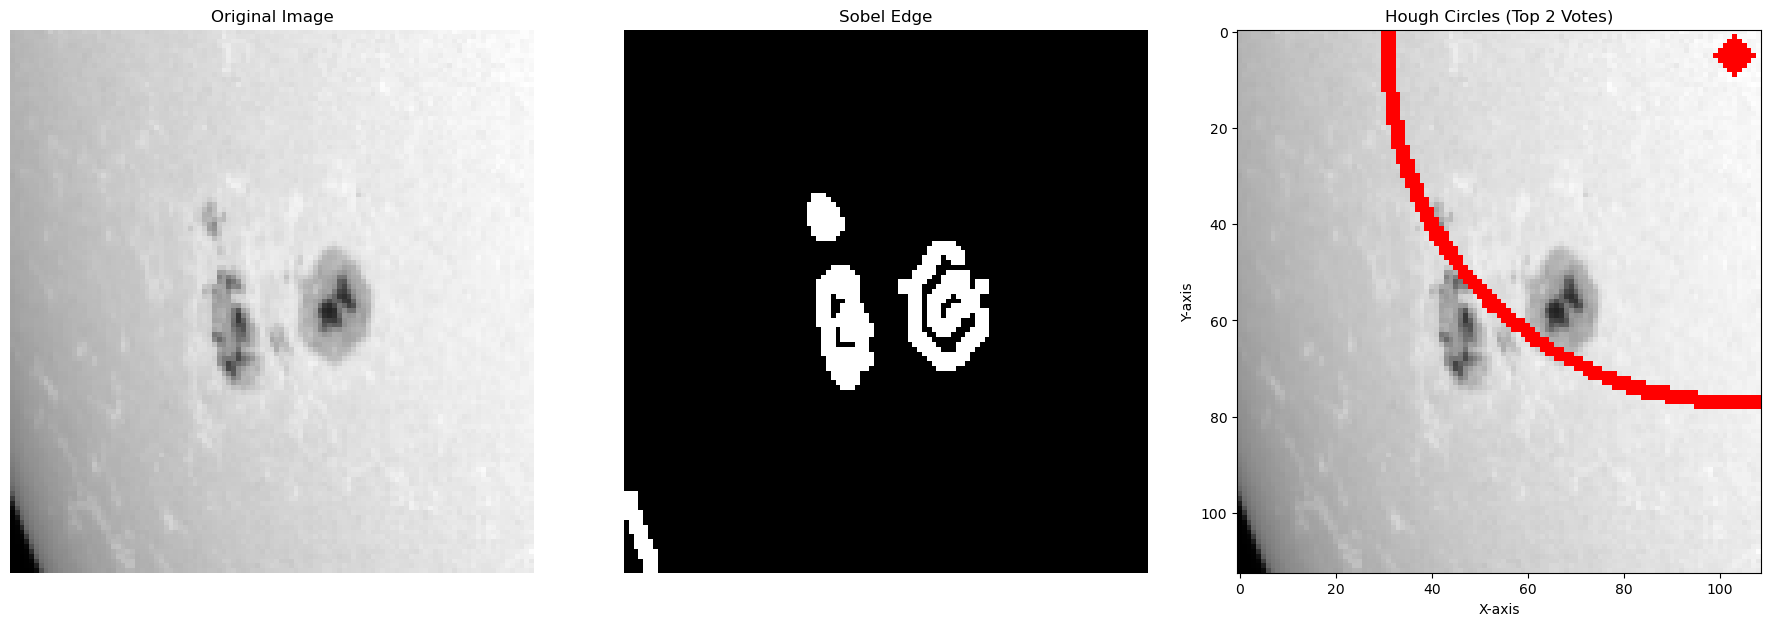

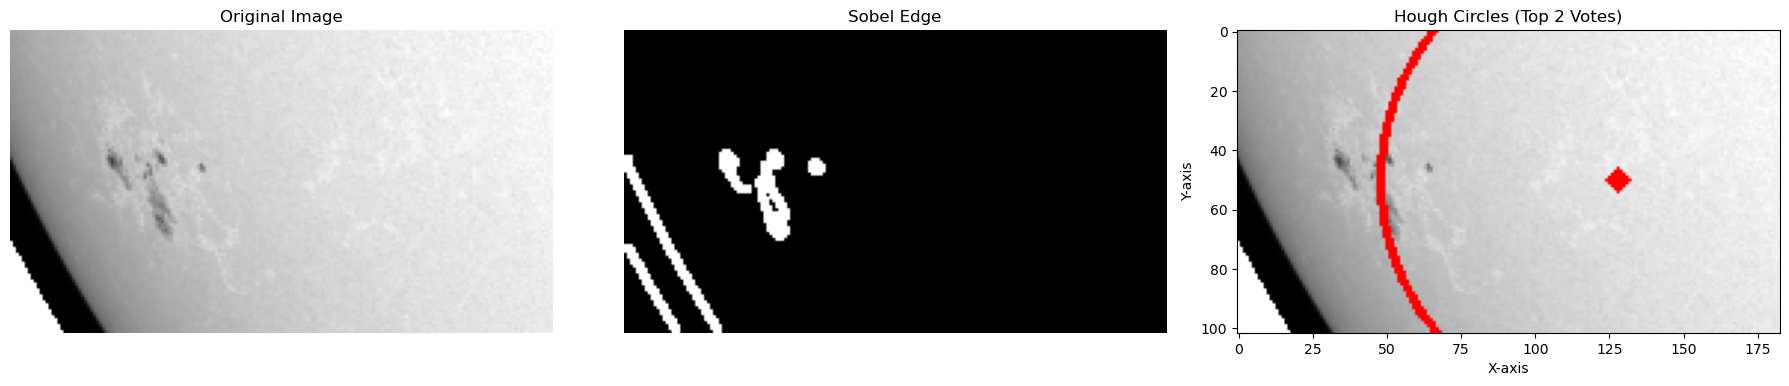

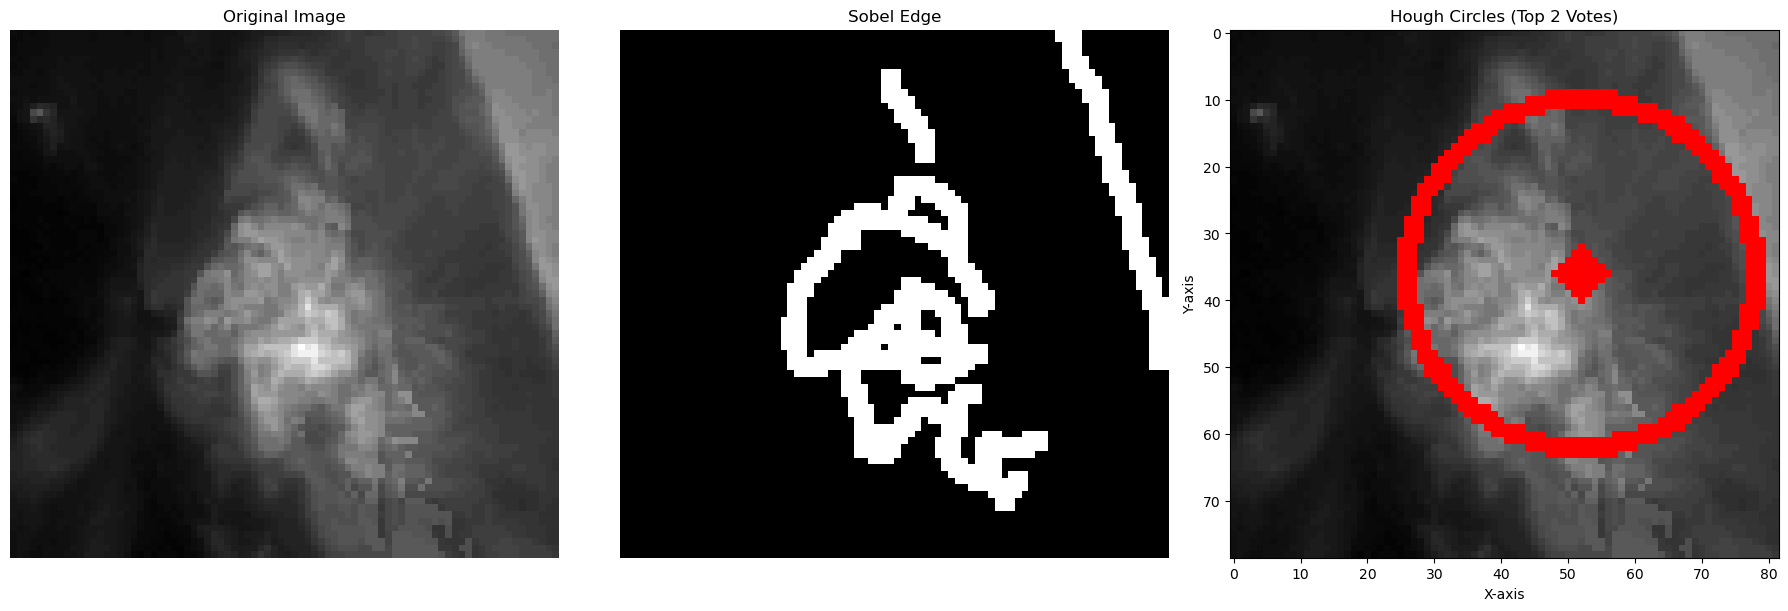

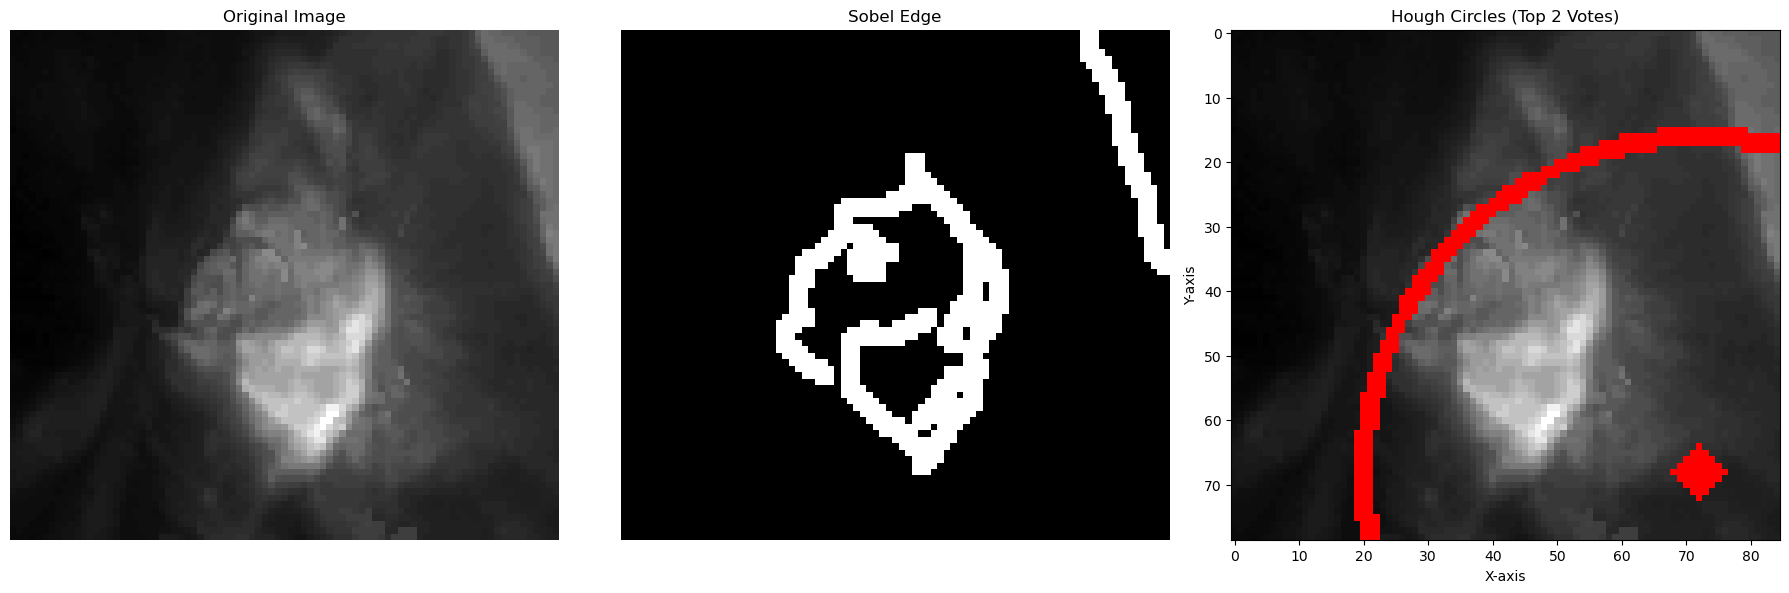

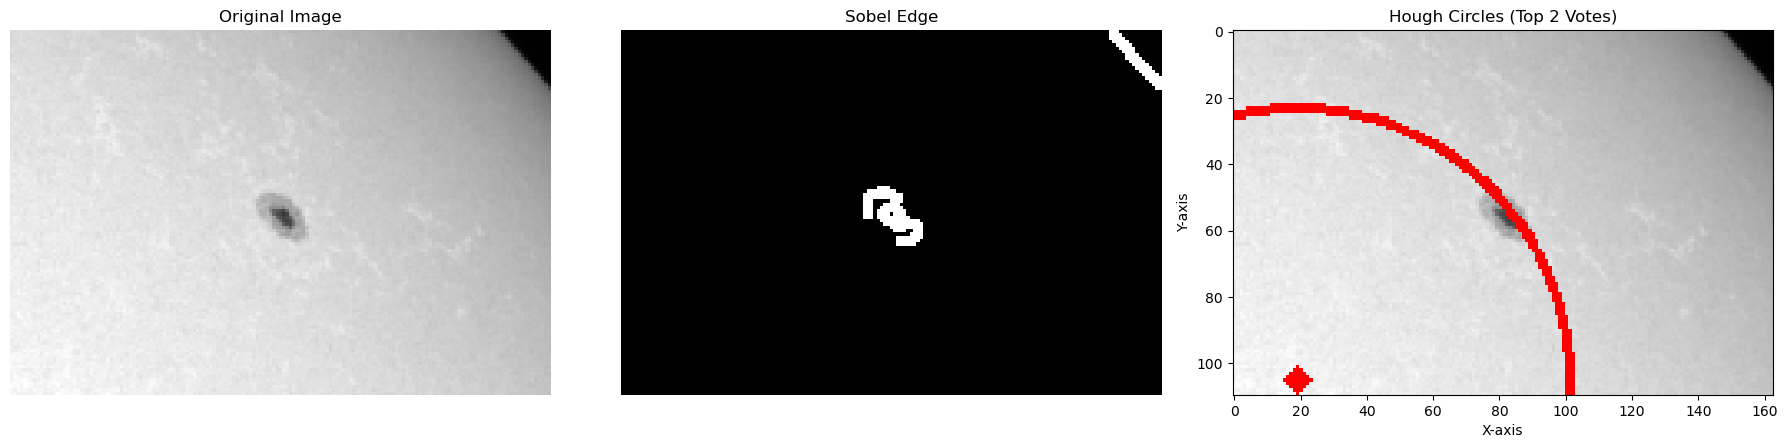

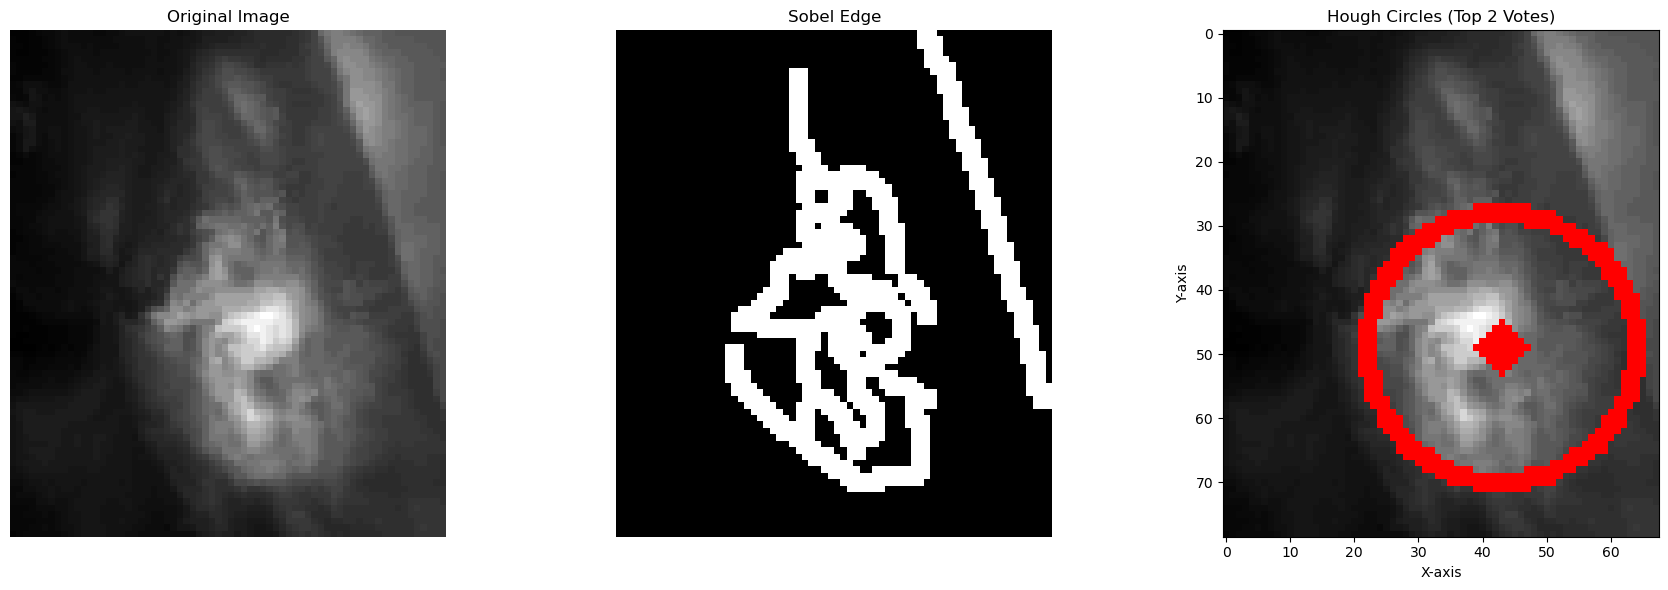

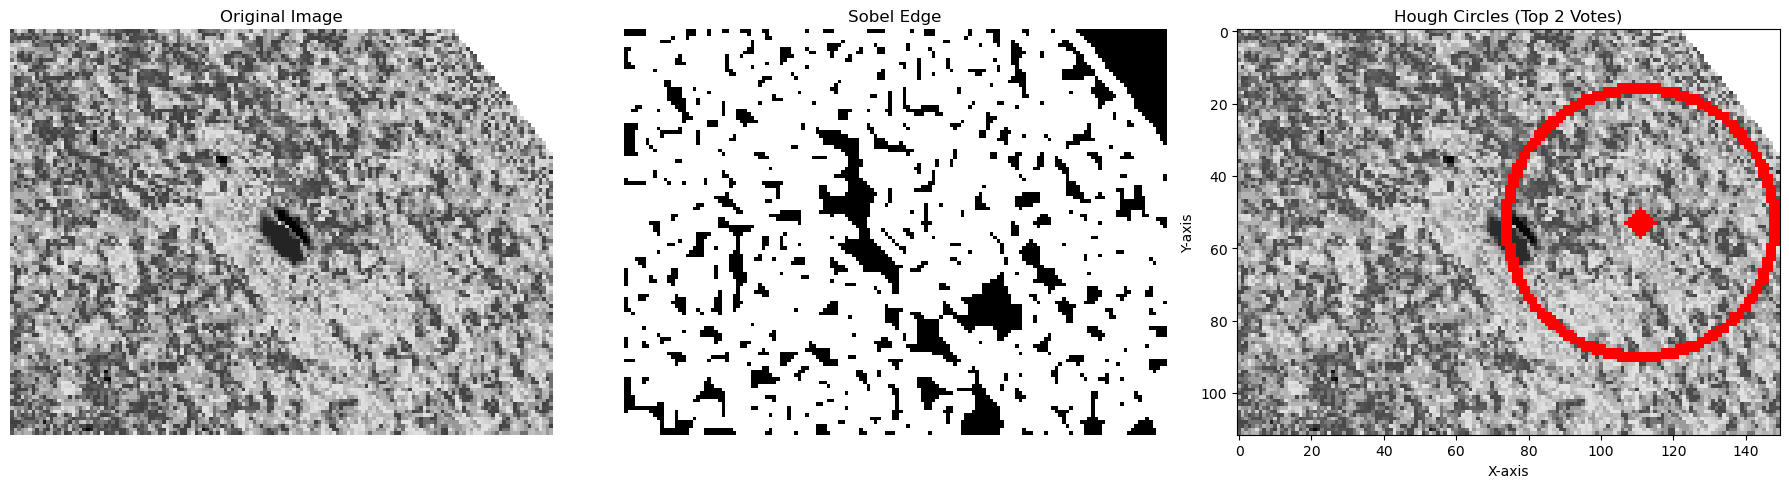

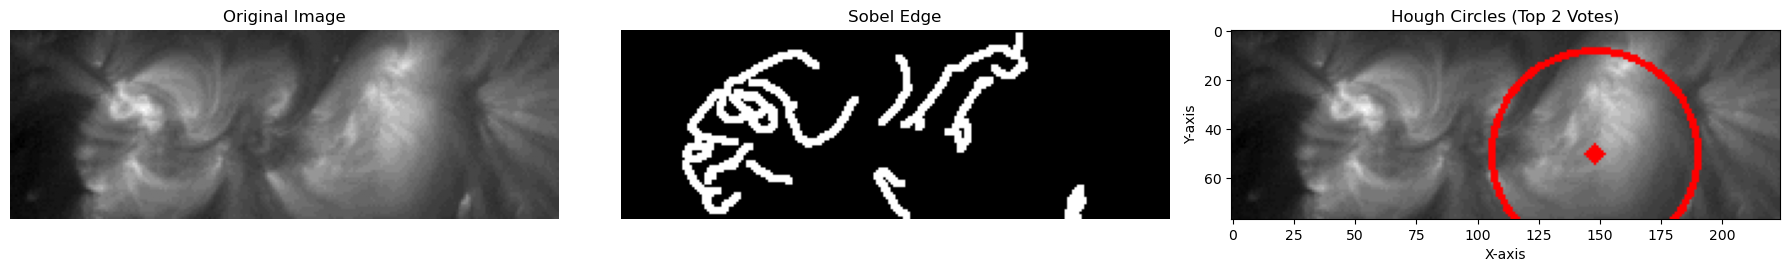

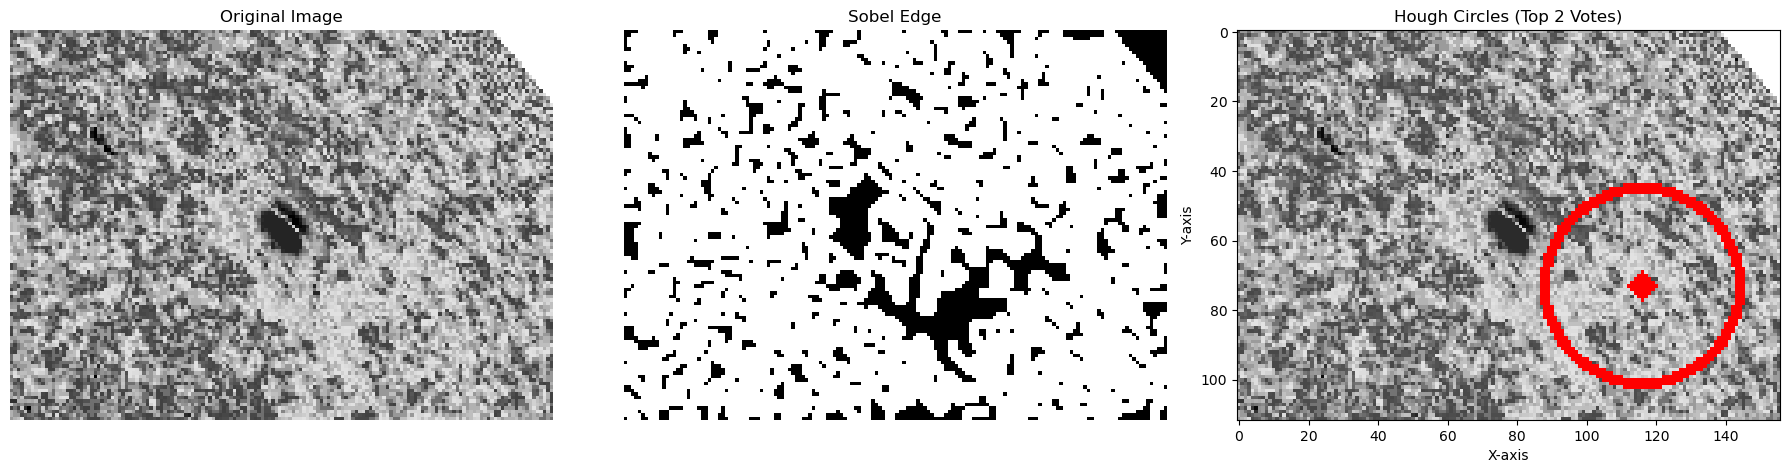

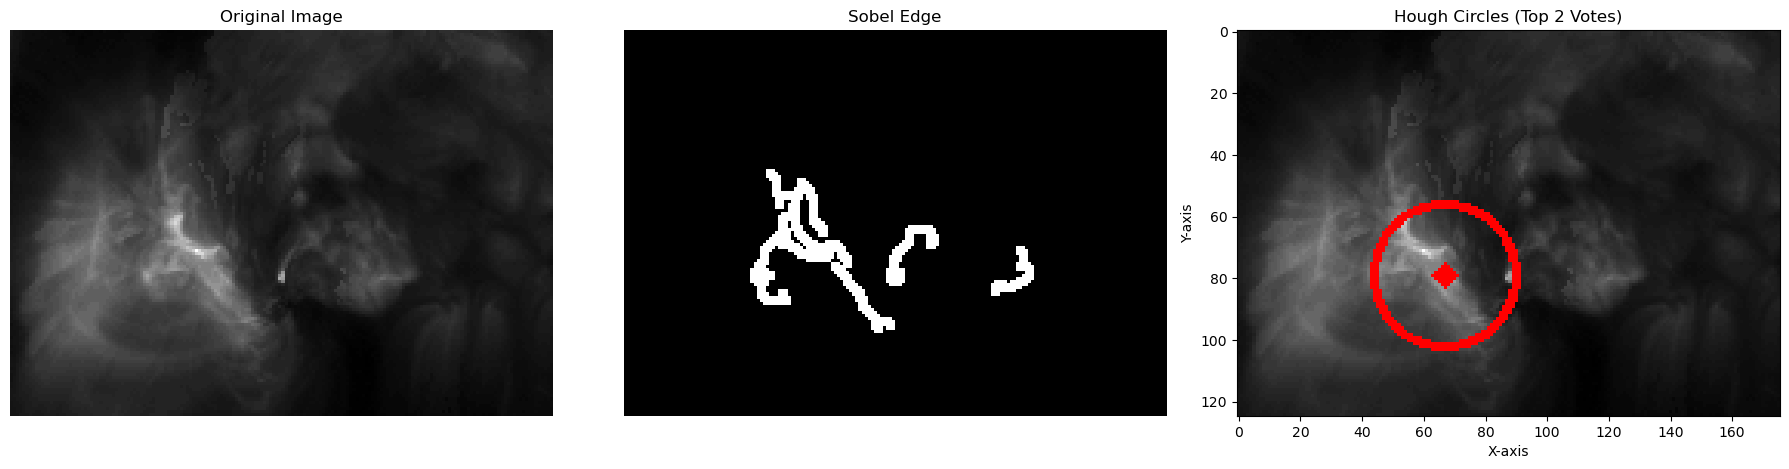

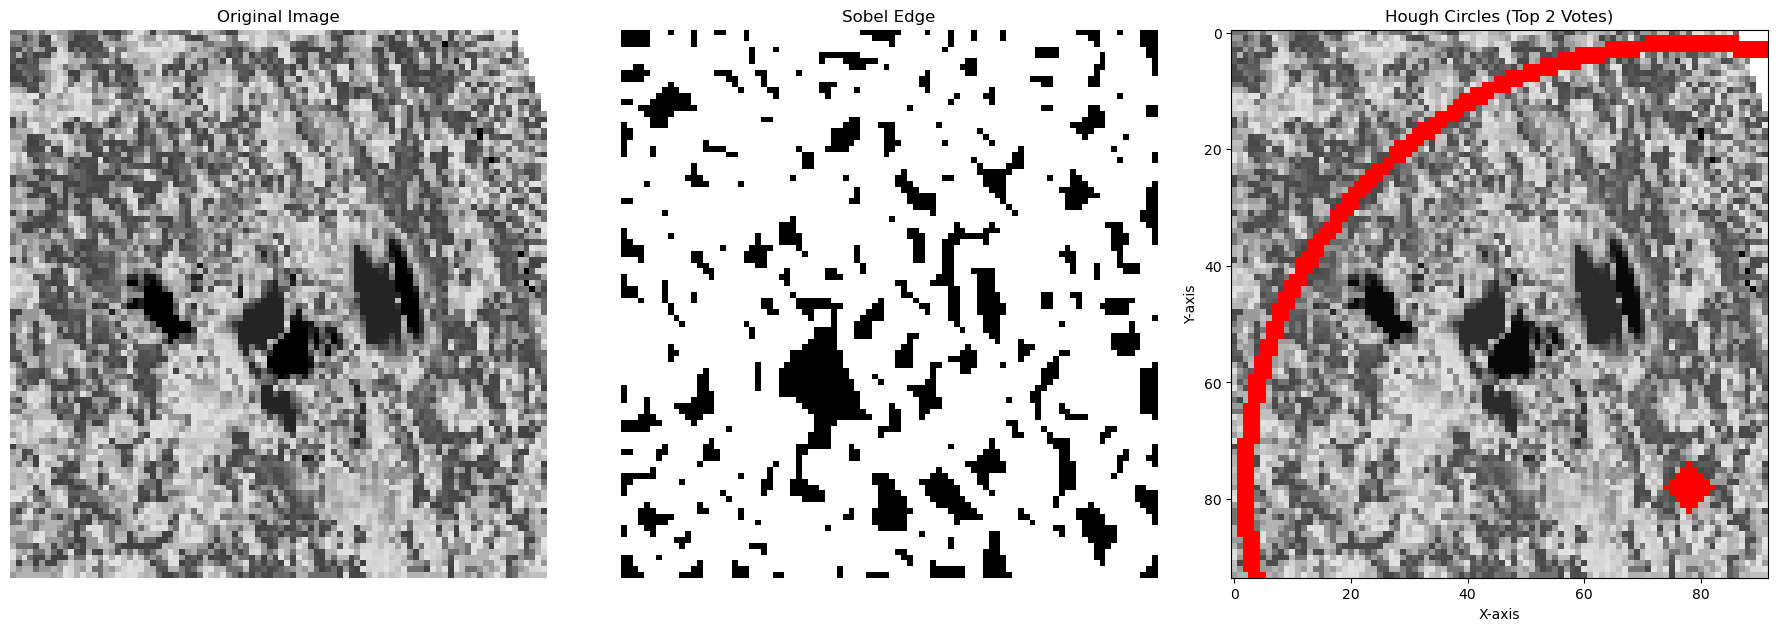

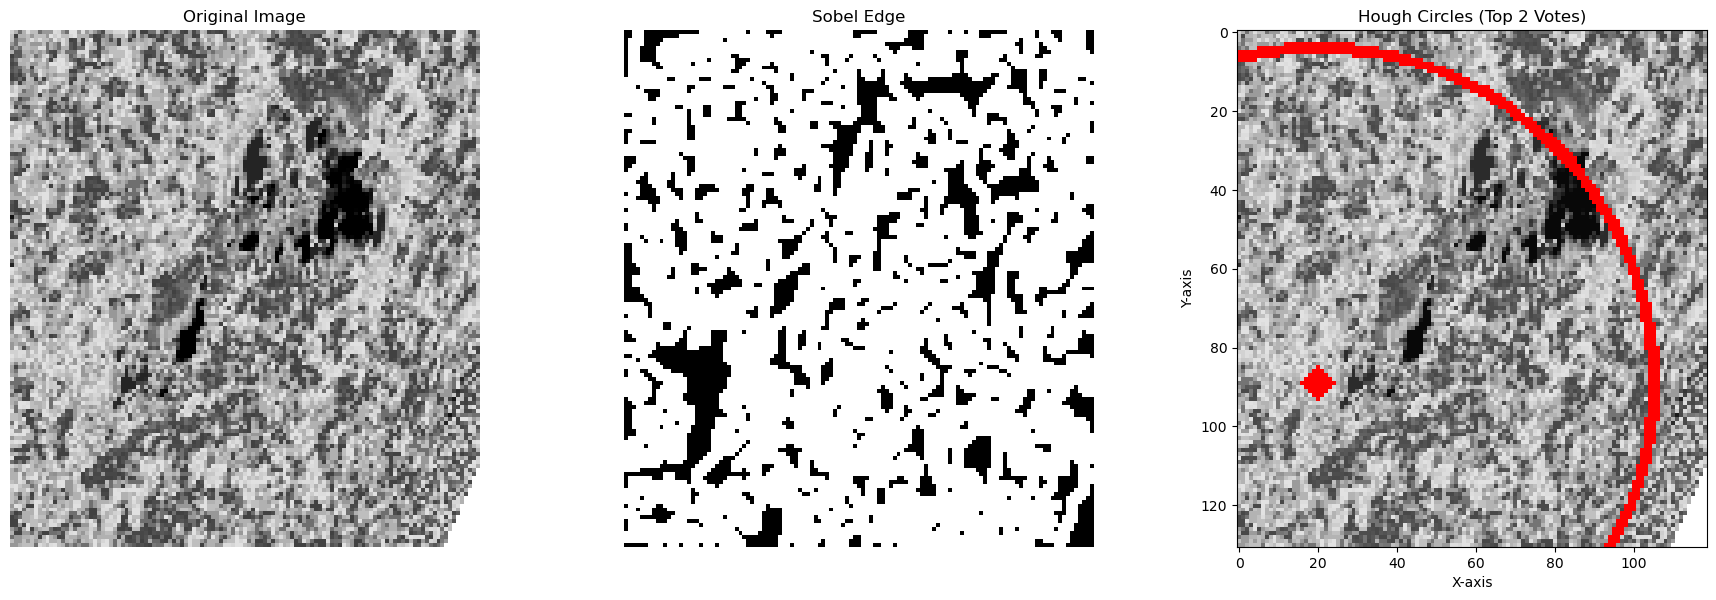

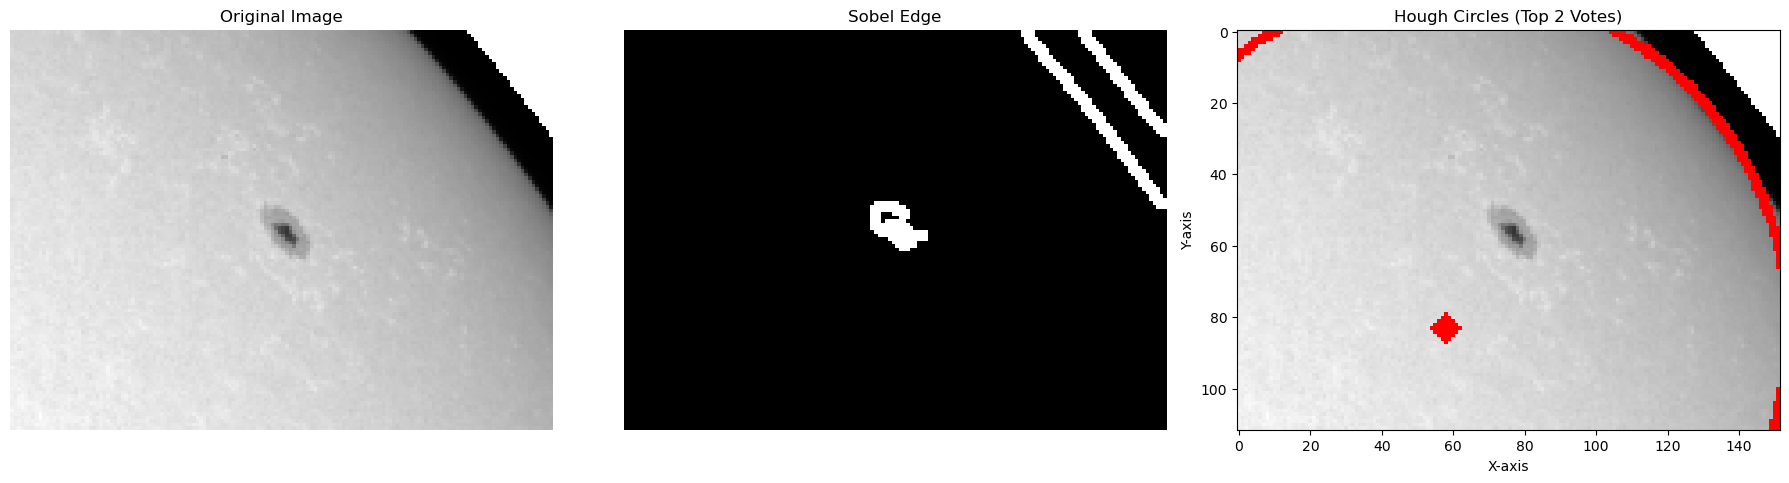

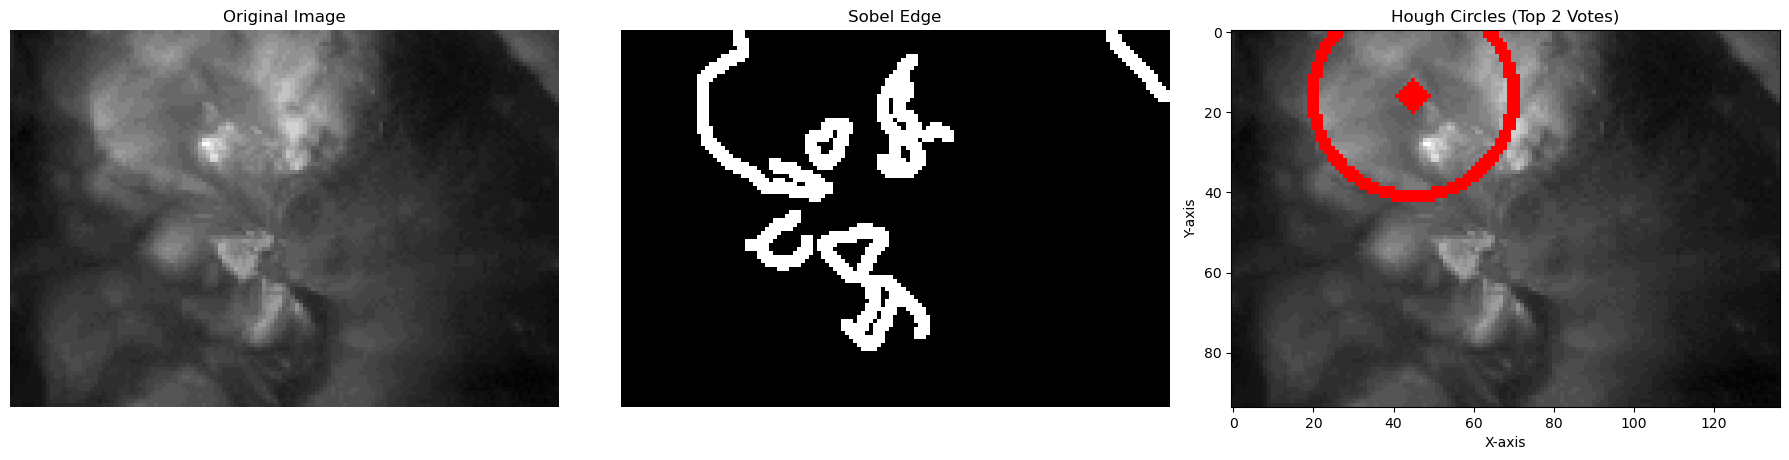

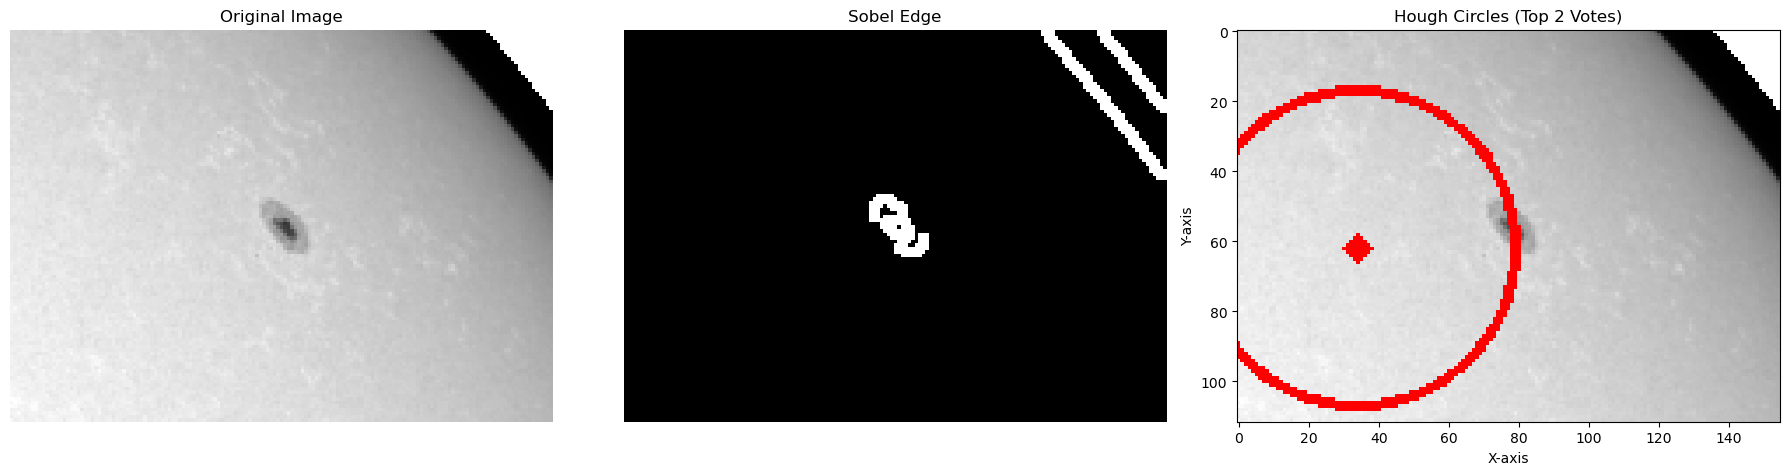

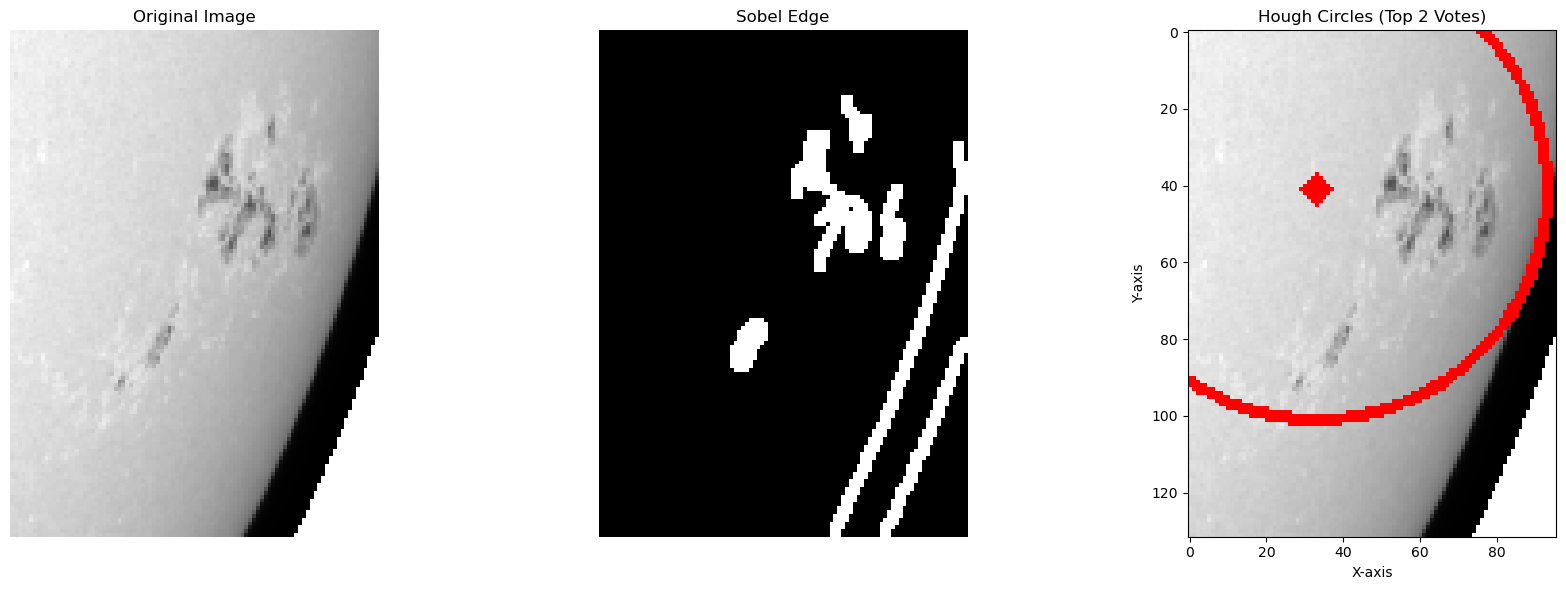

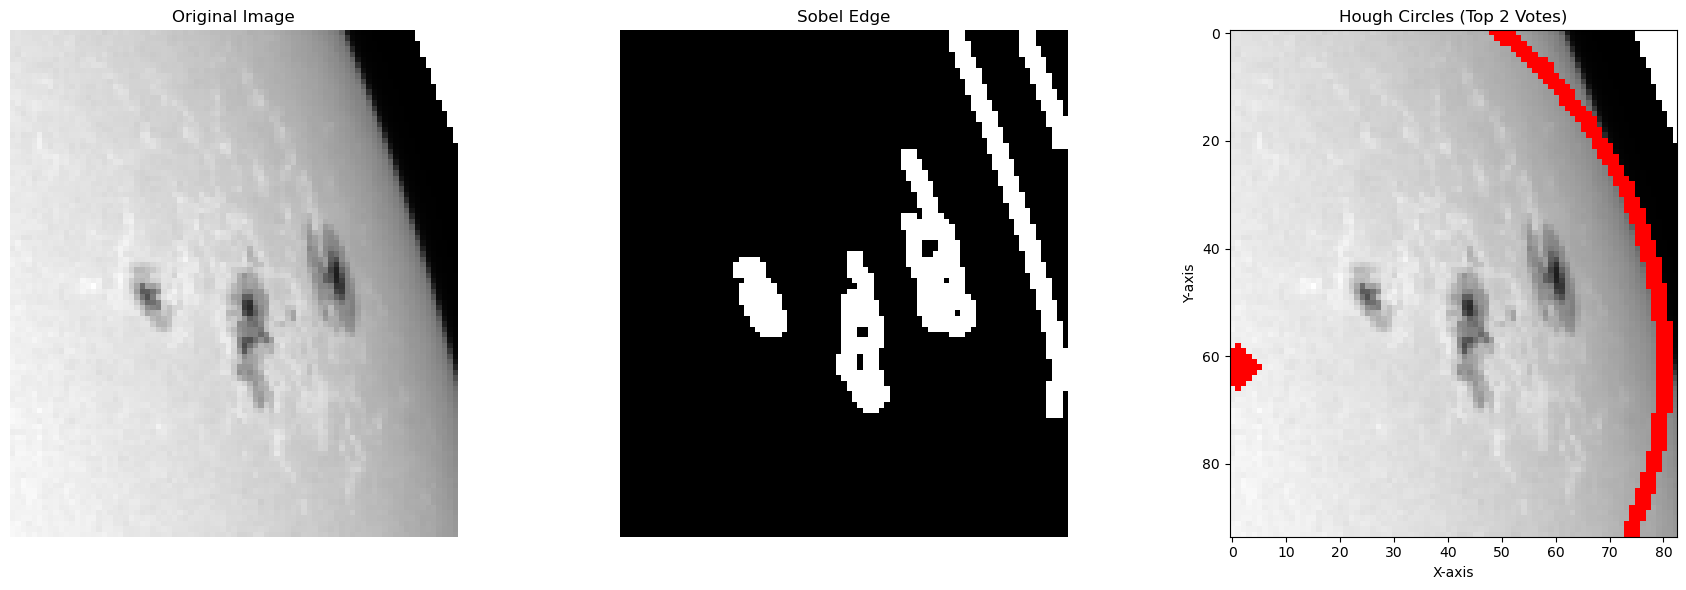

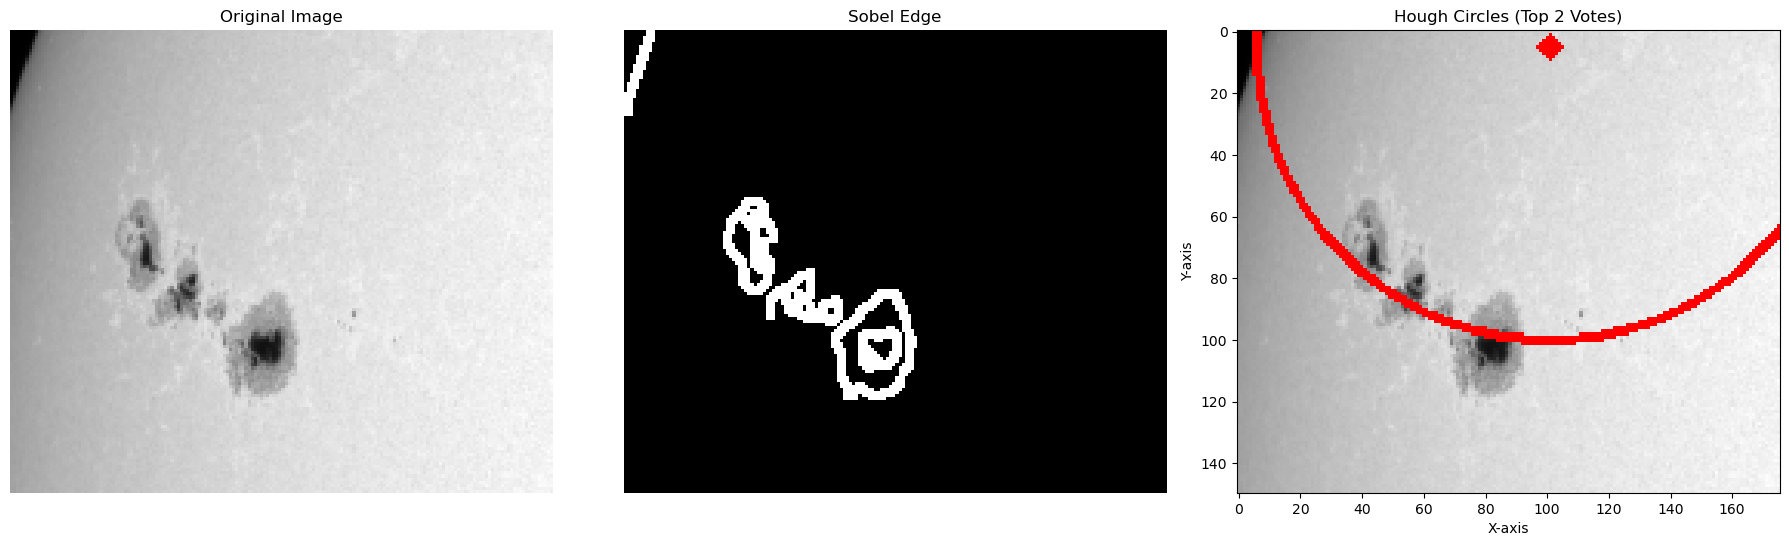

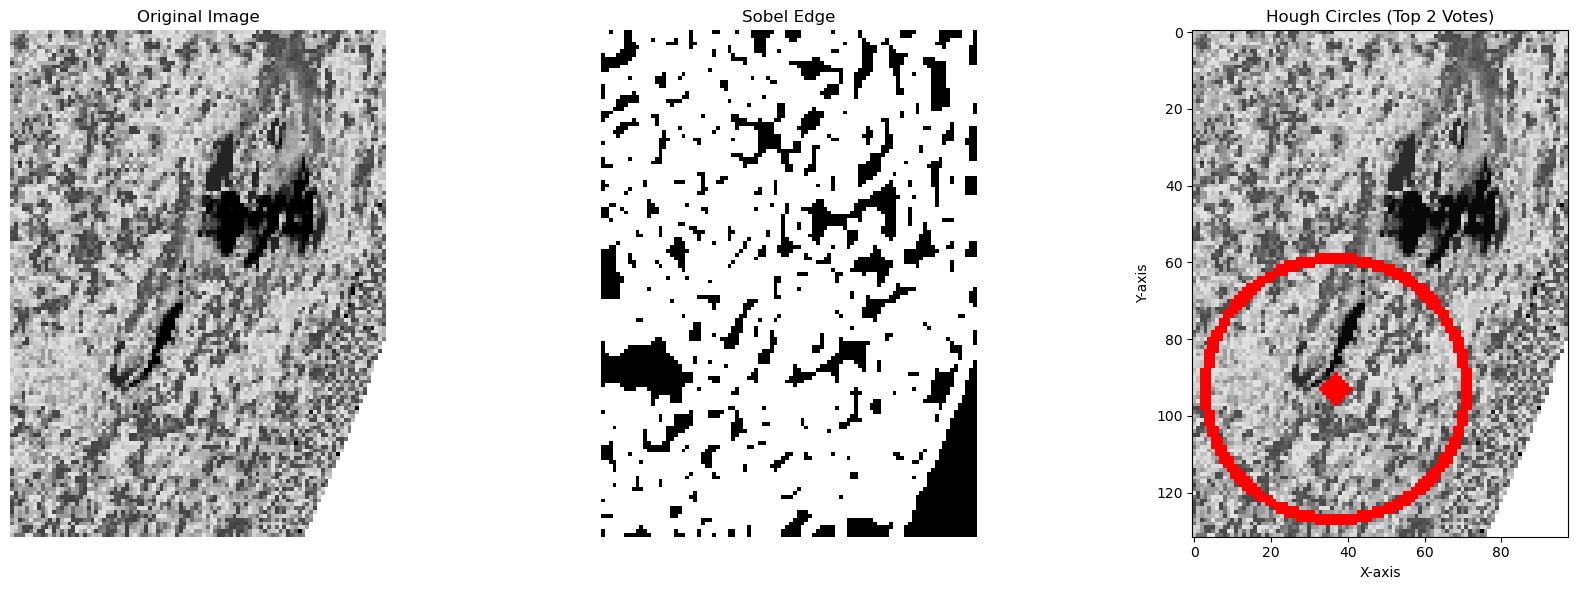

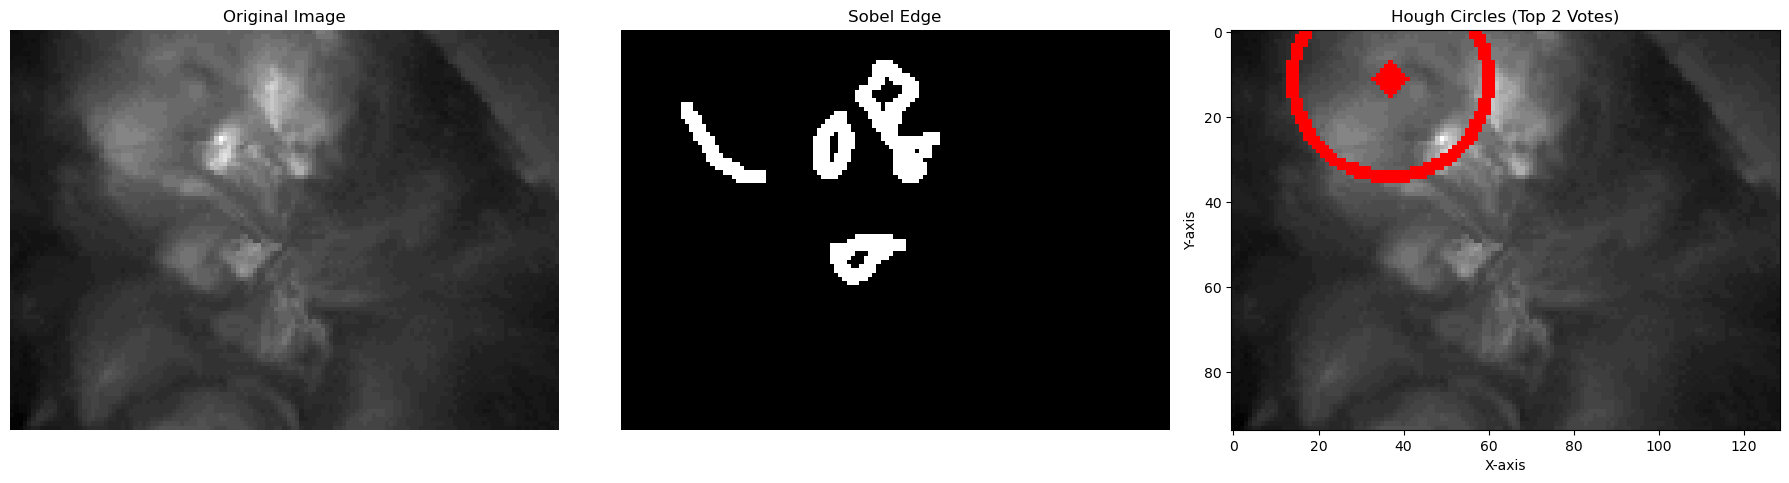

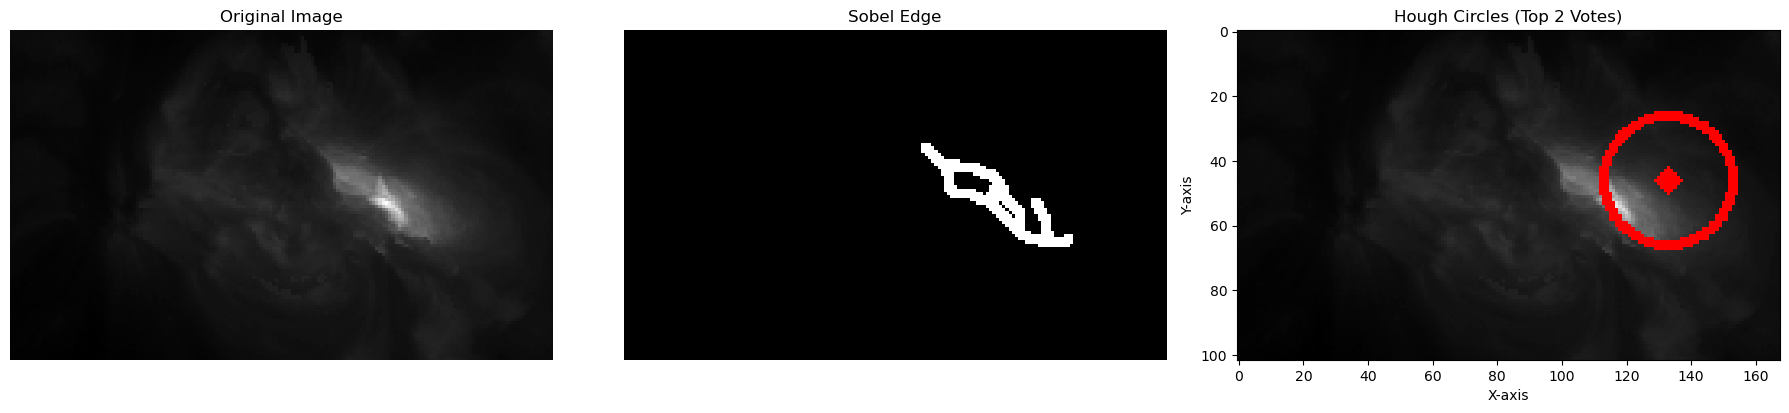

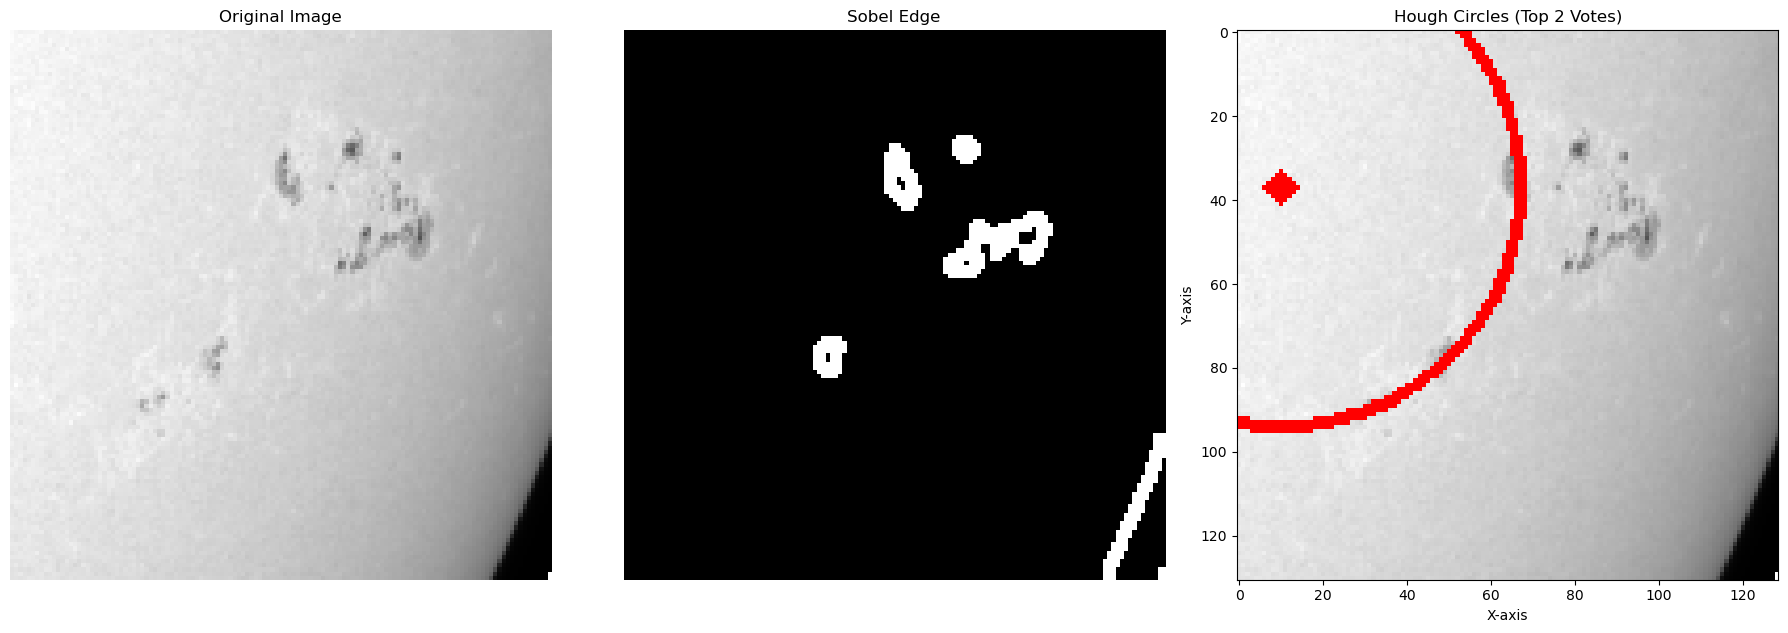

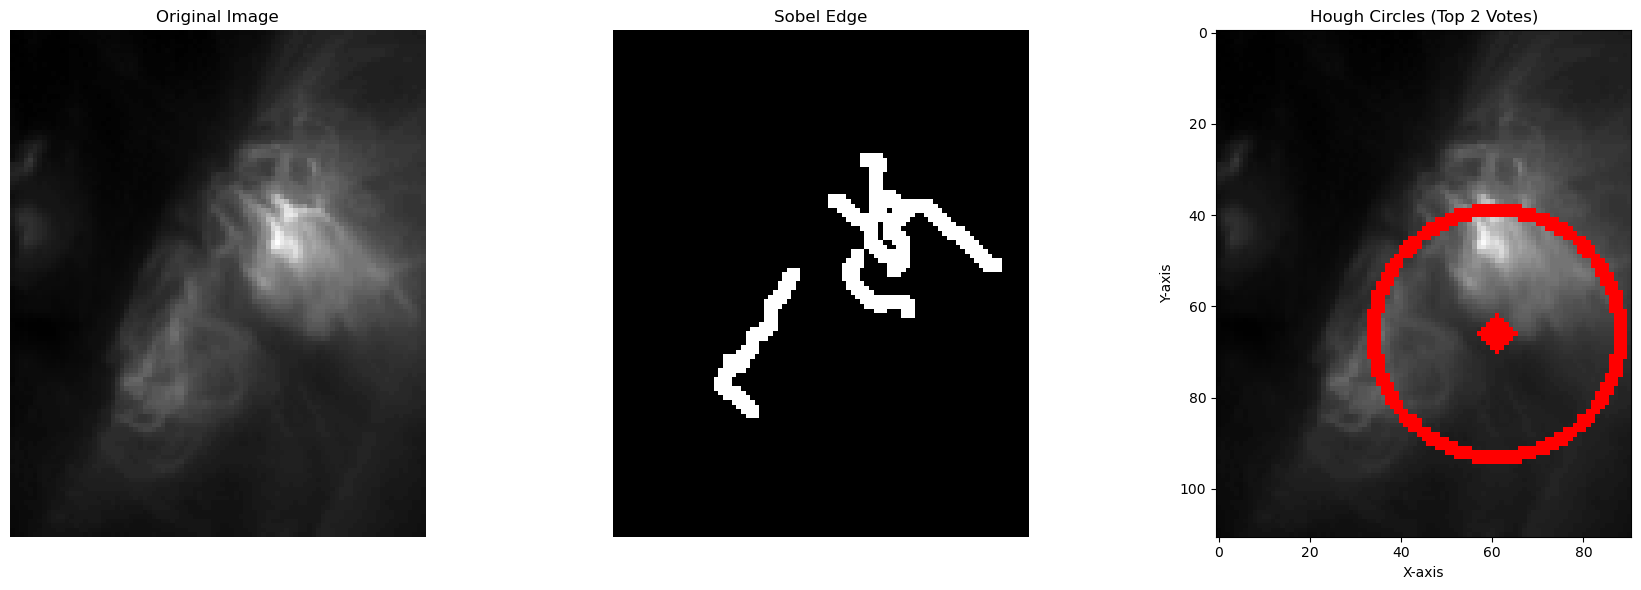

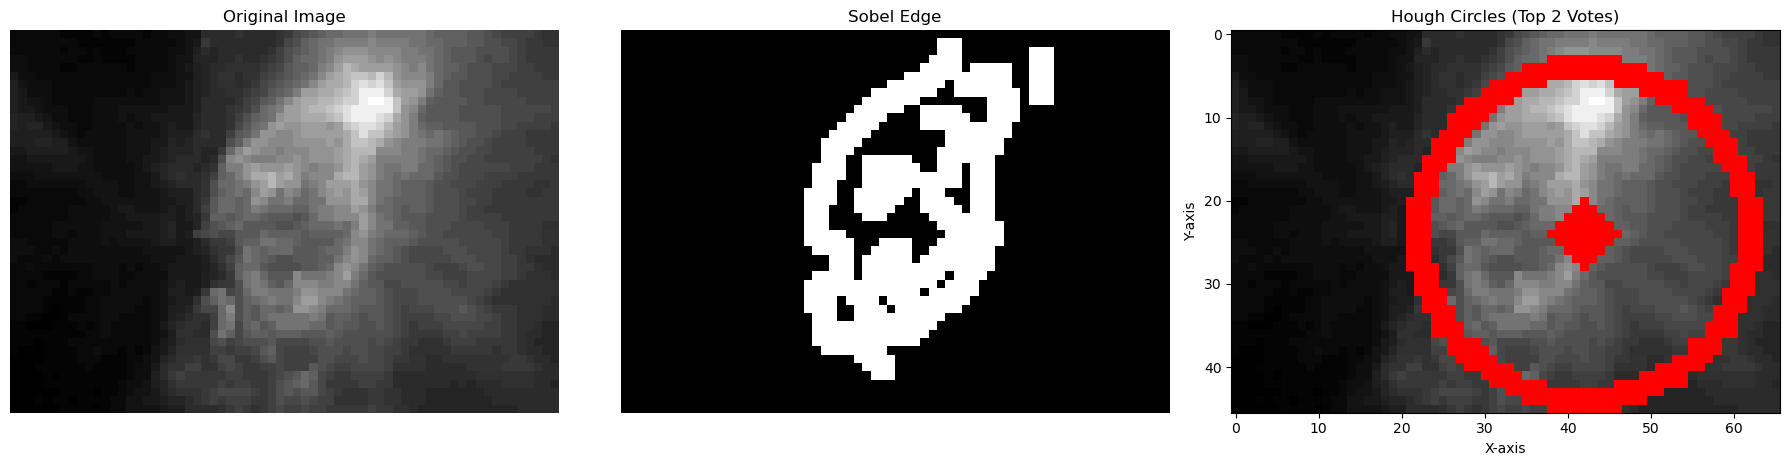

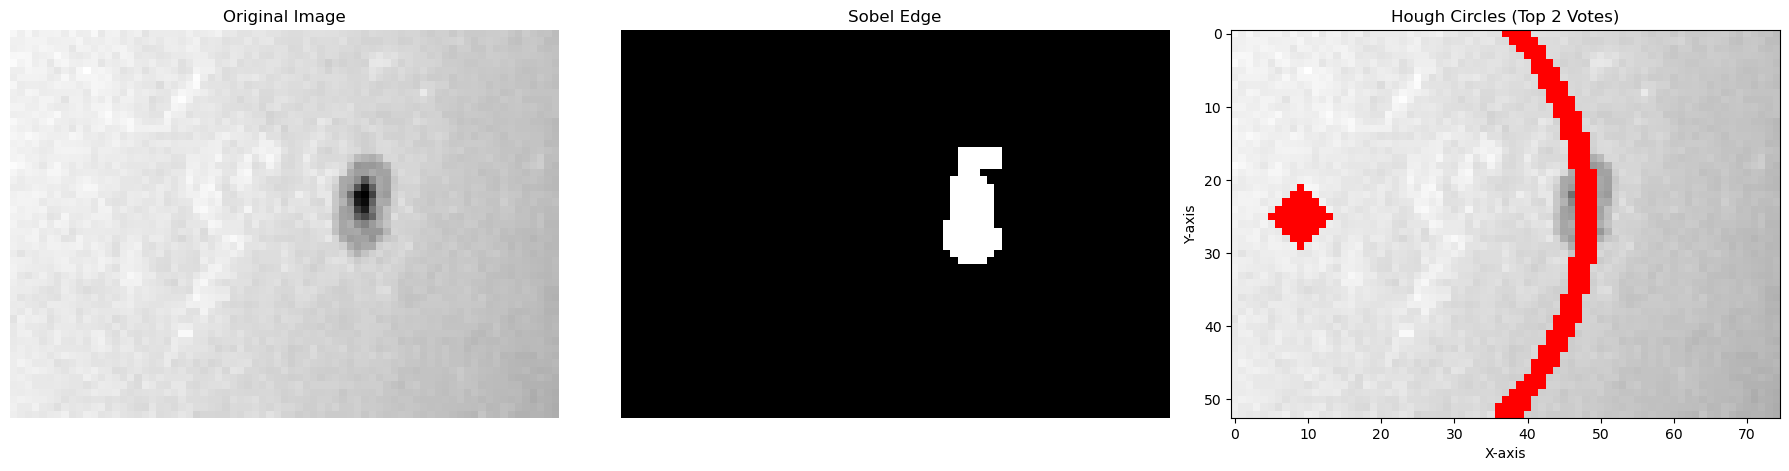

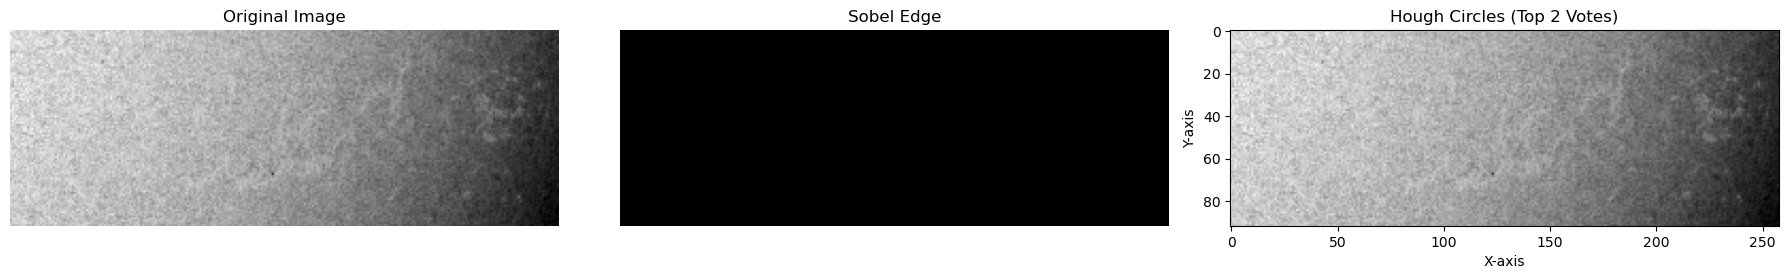

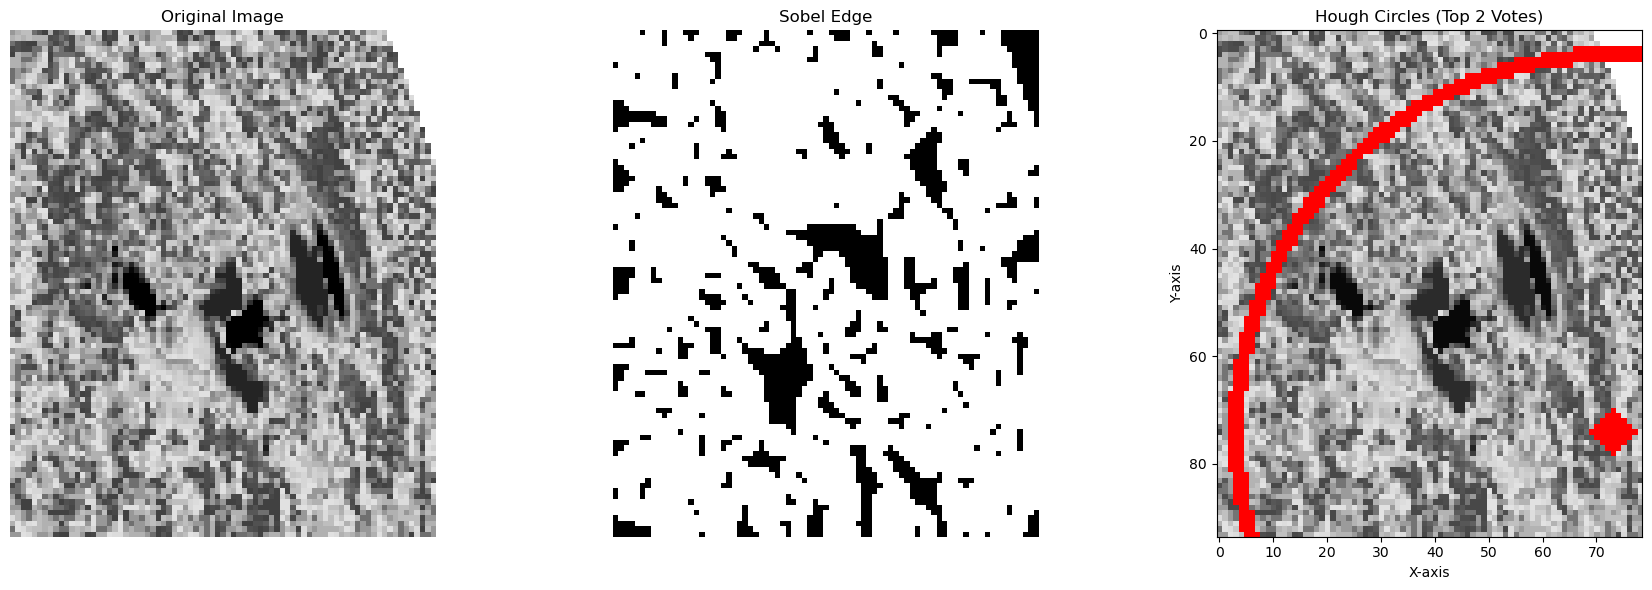

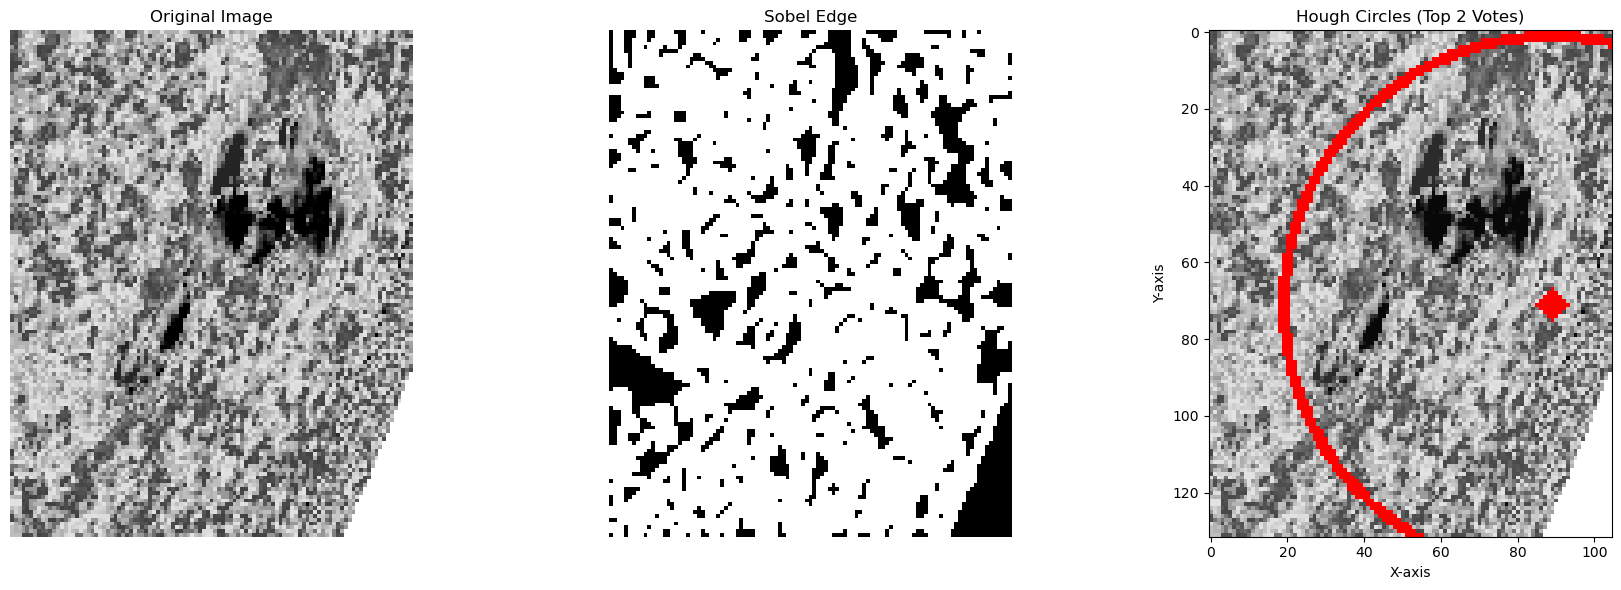

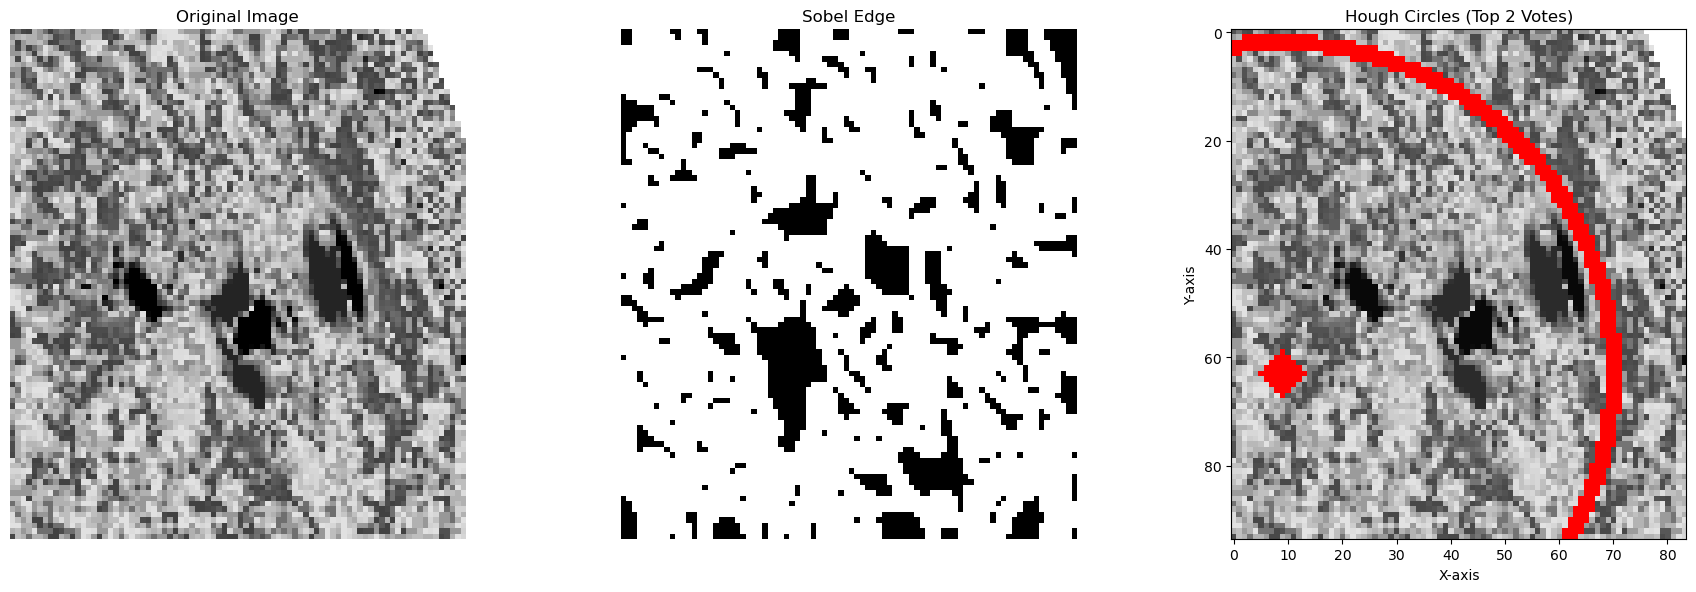

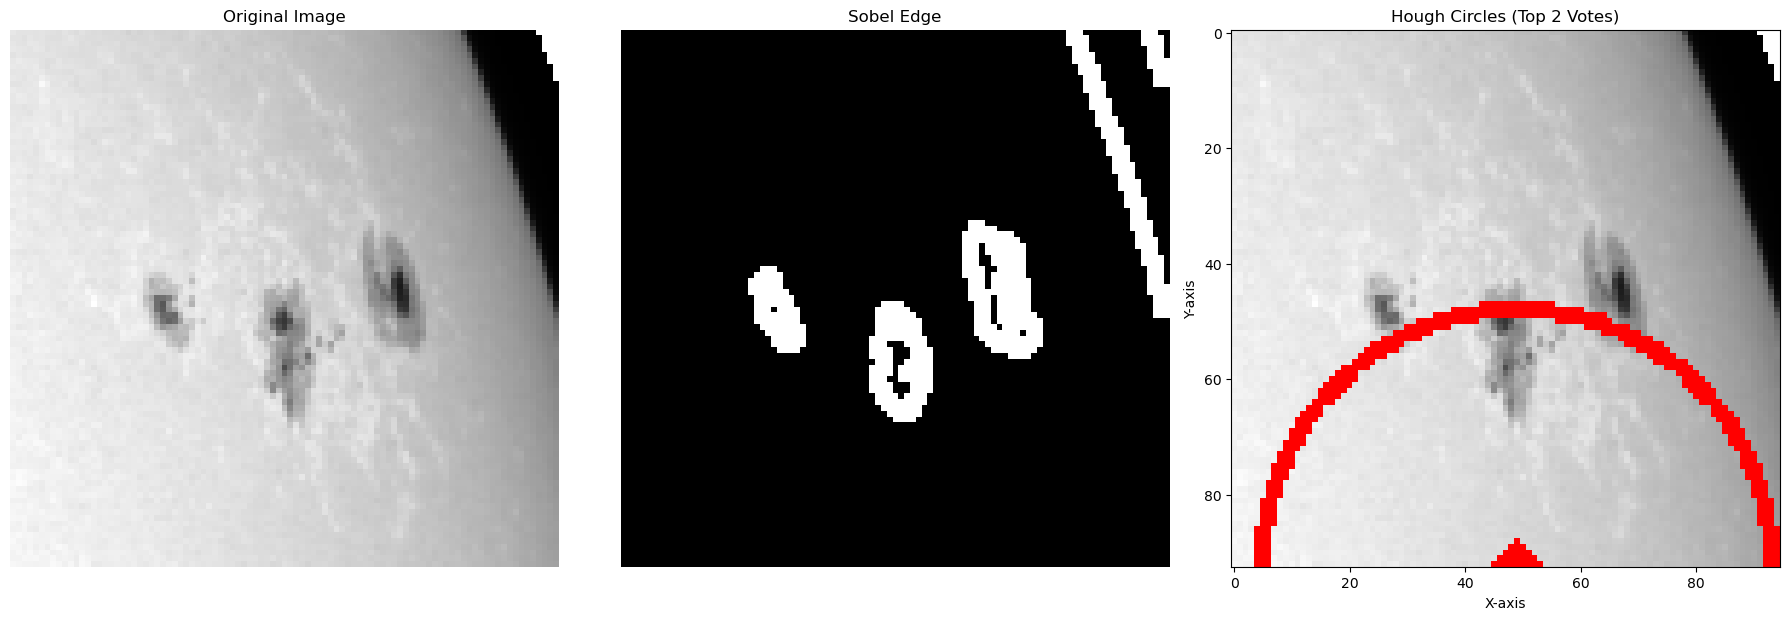

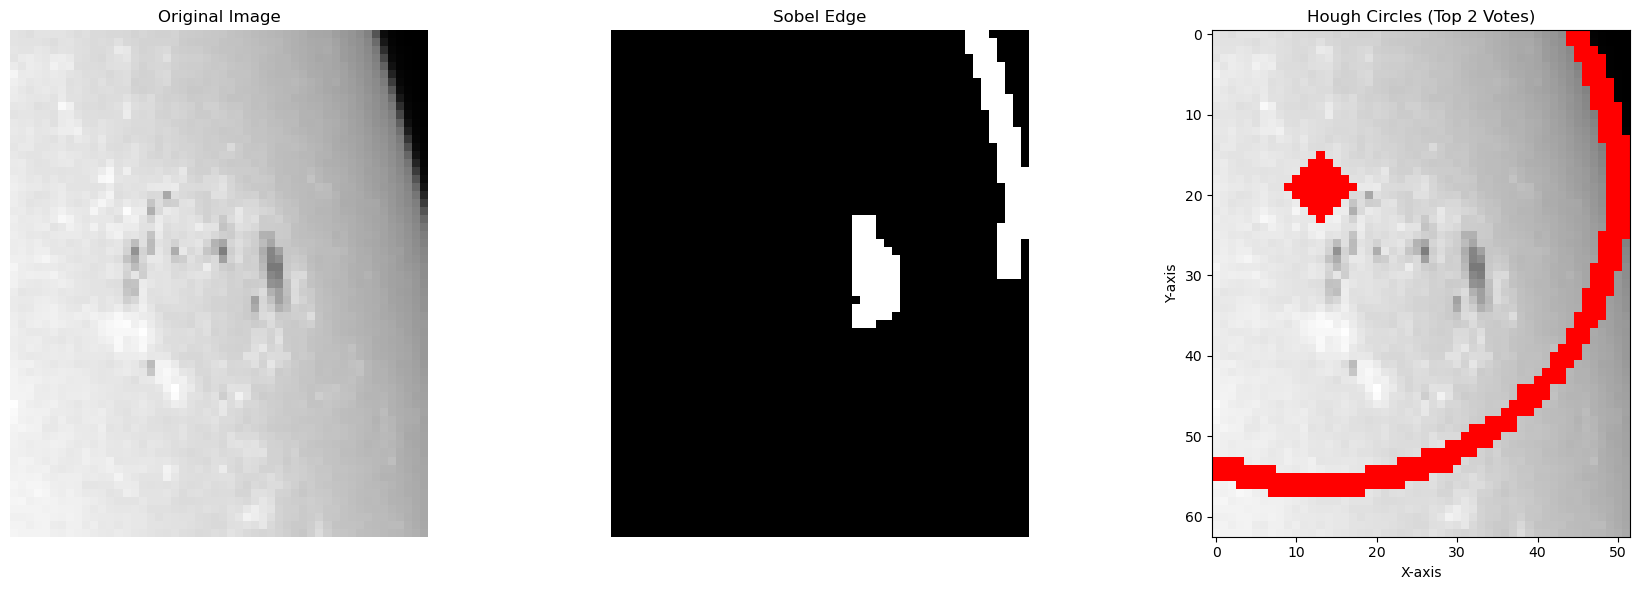

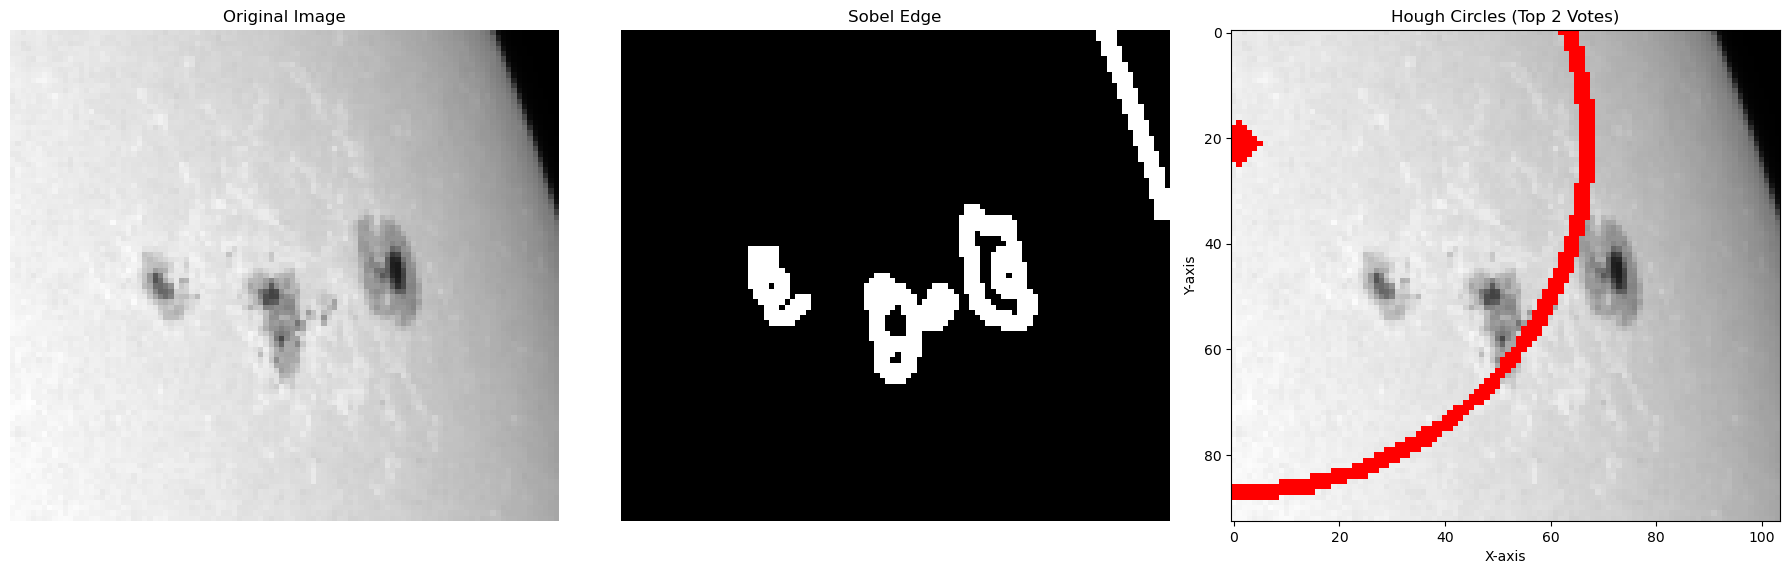

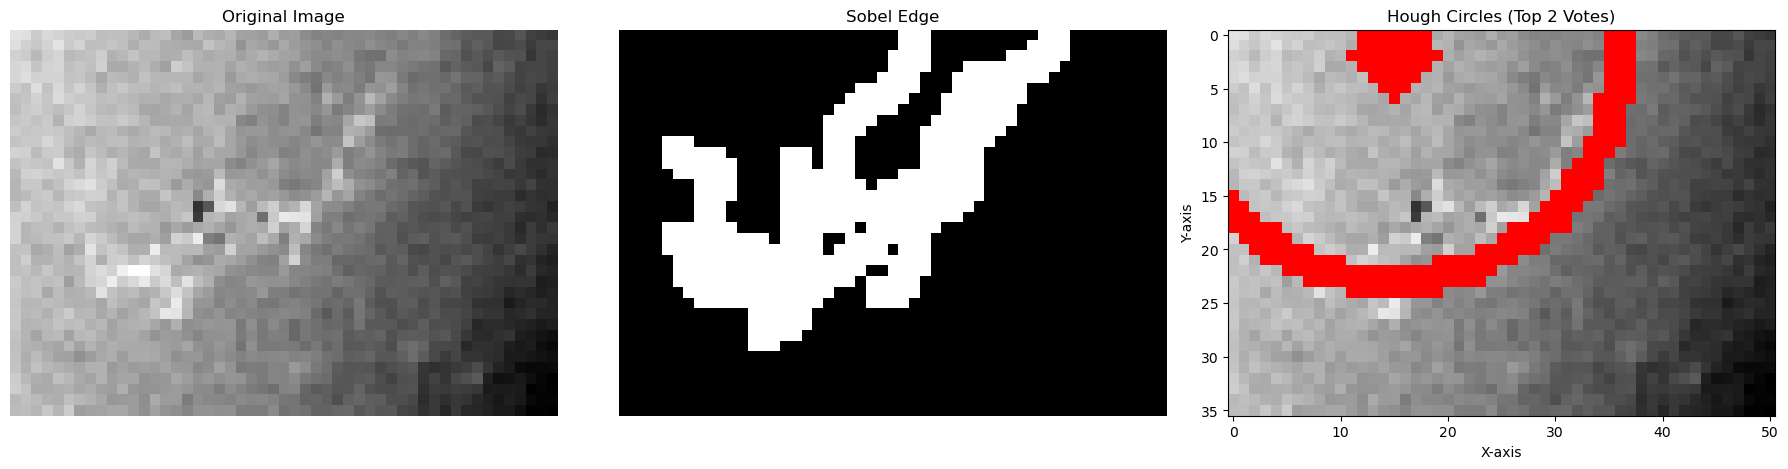

In [44]:
def process_images(image_paths):
    """
    Process a list of image paths and display three images for each:
    original, edge, and annotated (with Hough circles).
    
    Args:
        image_paths (list): List of file paths to images.
        
    Returns:
        results (dict): Dictionary mapping image path to a tuple of
                        (original, edge, annotated) images.
    """
    results = {}
    
    for image_path in image_paths:
        orig, edge, annotated = process_image2(image_path)
        results[image_path] = (orig, edge, annotated)
        
        # --- Display the Results for the current image ---
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image with axes turned off
        axs[0].imshow(orig, cmap="gray")
        axs[0].set_title("Original Image")
        axs[0].axis("off")
        
        # Edge image with axes turned off
        axs[1].imshow(edge, cmap="gray")
        axs[1].set_title("Sobel Edge")
        axs[1].axis("off")
        
        # Annotated image with circles and axes on
        axs[2].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Hough Circles (Top 2 Votes)")
        axs[2].axis("on")
        axs[2].set_xlabel("X-axis")
        axs[2].set_ylabel("Y-axis")
        
        plt.tight_layout()
        plt.show()
    
    return results

# Example usage:
# Get all PNG images from the sample_images folder.
image_files = glob.glob("../Solar_disk_hough_transformation/sample_images/*.png")
results = process_images(image_files)
